# 3D position and modification in RDkit

## Create aspirin mol and apply conformer search

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
pruneRmsThresh =0.7
nconf = 1000

mol = Chem.MolFromSmiles(smiles)
mol_c = Chem.Mol(mol)
mol_c = Chem.AddHs(mol_c)
etkdg = AllChem.ETKDGv3()
etkdg.pruneRmsThresh = pruneRmsThresh
AllChem.EmbedMultipleConfs(mol_c, nconf, etkdg)
nconf = mol_c.GetNumConformers()
prop = AllChem.MMFFGetMoleculeProperties(mol_c)

for i in range(nconf):
    mmff = AllChem.MMFFGetMoleculeForceField(mol_c, prop, confId=i)
    mmff.Minimize()

# Get the 3D coordinates of the conformers
coord = np.array(mol_c.GetConformer(0).GetPositions())

## Draw simple 3D structure

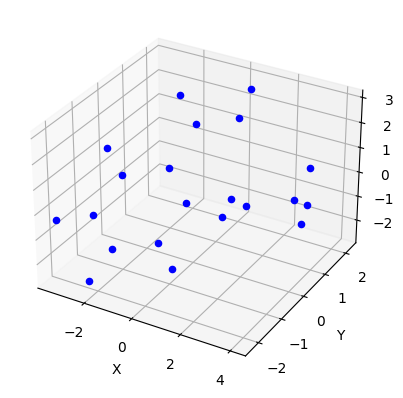

In [3]:
import matplotlib.pyplot as plt

x = coord[:, 0]
y = coord[:, 1]
z = coord[:, 2]

atom_types = [atom.GetSymbol() for atom in mol_c.GetAtoms()]

color_map = {
    'H': 'green',
    'C': 'black',
    'O': 'red',
}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for xi, yi, zi, atom_type in zip(x, y, z, atom_types):
    ax.scatter(xi, yi, zi, c='b', marker='o', label=atom_type)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.show()


## Mirror interaction and visualization

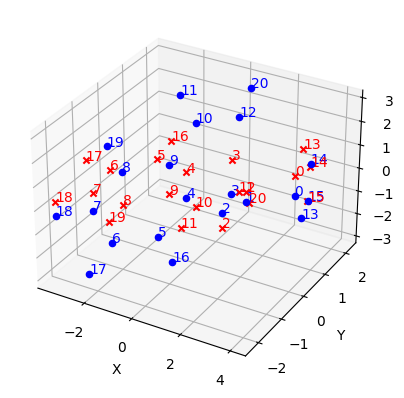

In [4]:
from rdkit import Geometry as Geom
import matplotlib.pyplot as plt
import numpy as np

coord_c = coord.copy()
coord_c[:, 2] = coord_c[:, 2] * -1.0

for i in range(mol_c.GetNumAtoms()):
    mol_c.GetConformer(0).SetAtomPosition(i, Geom.Point3D(coord_c[i, 0], coord_c[i, 1], coord_c[i, 2]))

x_c = coord_c[:, 0]
y_c = coord_c[:, 1]
z_c = coord_c[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
    ax.scatter(xi, yi, zi, c='b', marker='o')
    ax.text(xi, yi, zi, str(i), color='blue')

for i, (xi, yi, zi) in enumerate(zip(x_c, y_c, z_c)):
    ax.scatter(xi, yi, zi, c='r', marker='x')
    ax.text(xi, yi, zi, str(i), color='red')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

## Draw center plate of molecule

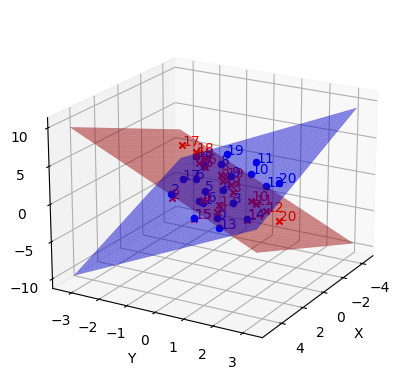

In [5]:
from rdkit import Geometry as Geom
import matplotlib.pyplot as plt

coord_c = coord.copy()
coord_c[:, 2] = coord_c[:, 2] * -1.0

for i in range(mol_c.GetNumAtoms()):
    mol_c.GetConformer(0).SetAtomPosition(i, Geom.Point3D(coord_c[i, 0], coord_c[i, 1], coord_c[i, 2]))

x_c = coord_c[:, 0]
y_c = coord_c[:, 1]
z_c = coord_c[:, 2]

center_x = np.mean(x)
center_y = np.mean(y)
center_z = np.mean(z)

center_x_c = np.mean(x_c)
center_y_c = np.mean(y_c)
center_z_c = np.mean(z_c)

xx, yy = np.meshgrid(np.linspace(min(x) - 1, max(x) + 1, 50),
                     np.linspace(min(y) - 1, max(y) + 1, 50))
zz = np.full_like(xx, center_z)

xx_c, yy_c = np.meshgrid(np.linspace(min(x_c) - 1, max(x_c) + 1, 50),
                         np.linspace(min(y_c) - 1, max(y_c) + 1, 50))
zz_c = np.full_like(xx_c, center_z_c)

from sklearn.decomposition import PCA

def fit_plane_and_plot(coord, color, marker):
    pca = PCA(n_components=3)
    pca.fit(coord)
    
    center = np.mean(coord, axis=0)
    normal_vector = pca.components_[-1]
    
    xx, yy = np.meshgrid(np.linspace(min(coord[:, 0]) - 1, max(coord[:, 0]) + 1, 50),
                         np.linspace(min(coord[:, 1]) - 1, max(coord[:, 1]) + 1, 50))
    
    zz = (-normal_vector[0] * (xx - center[0]) - normal_vector[1] * (yy - center[1]) + normal_vector[2] * center[2]) / normal_vector[2]
    
    for i, (xi, yi, zi) in enumerate(coord):
        ax.scatter(xi, yi, zi, c=color, marker=marker)
        ax.text(xi, yi, zi, str(i), color=color)
    
    ax.plot_surface(xx, yy, zz, alpha=0.5, color=color)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

coord_c = coord.copy()
coord_c[:, 2] = coord_c[:, 2] * -1.0

fit_plane_and_plot(coord, 'b', 'o')

fit_plane_and_plot(coord_c, 'r', 'x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=20., azim=30)
plt.show()
